# Marginalizing over long-term velocity trends

New with v0.3, The Joker now supports sampling over polynomial, long-term velocity trends. In this example, we'll walk through a demo of how to set up and run the sampler while allowing for a quadratic (in time), long-term trend to the velocity data.

In [1]:
from astropy.time import Time
import astropy.units as u
import numpy as np
%matplotlib inline

from thejoker import RVData, JokerPrior, TheJoker
from thejoker.plot import plot_rv_curves

For this example, I've already pre-generated some simulated data that we're going to use -- the true parameters of the main orbit are in the cell below:

In [2]:
true_P = 61.1166 * u.day
true_e = 0.0324

The data are provided in-line in the next cell:

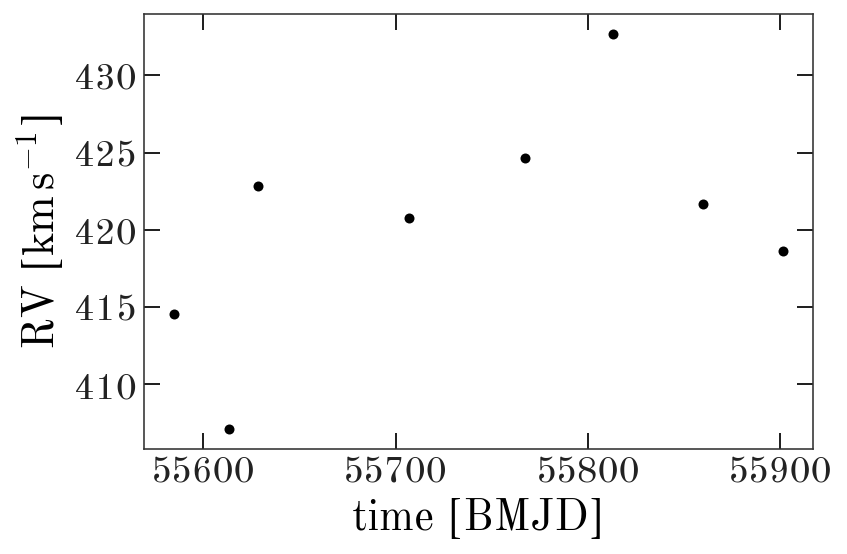

In [4]:
t = Time([55812.875, 55613.374, 55767.244, 55860.052,
          55901.232, 55584.778, 55706.921, 55628.590], 
         format='mjd', scale='tcb')
rv = [432.67367, 407.14526, 424.64327, 421.69321, 
      418.64374, 414.52811, 420.76149, 422.84962] * u.km/u.s
rv_err = [25, 25, 25, 25, 25, 25, 25, 25] * u.m/u.s
data = RVData(t, rv, rv_err)
_ = data.plot()

Based on the range of dates of the data, we'll set the period range to be somewhat restricted, since we don't need to consider period ranges much longer than the span of the data. To start with, we'll run the sampler in the default mode, which only tries to infer a constant offset (systemic) velocity for the system (i.e. no trend):

In [6]:
prior = JokerPrior.default(P_min=2*u.day, P_max=1024*u.day,
                           sigma_K0=30*u.km/u.s,
                           sigma_v=100*u.km/u.s)

In [7]:
prior_samples = prior.sample(size=1_000_000)

In [8]:
joker = TheJoker(prior)
samples = joker.rejection_sample(data, prior_samples)

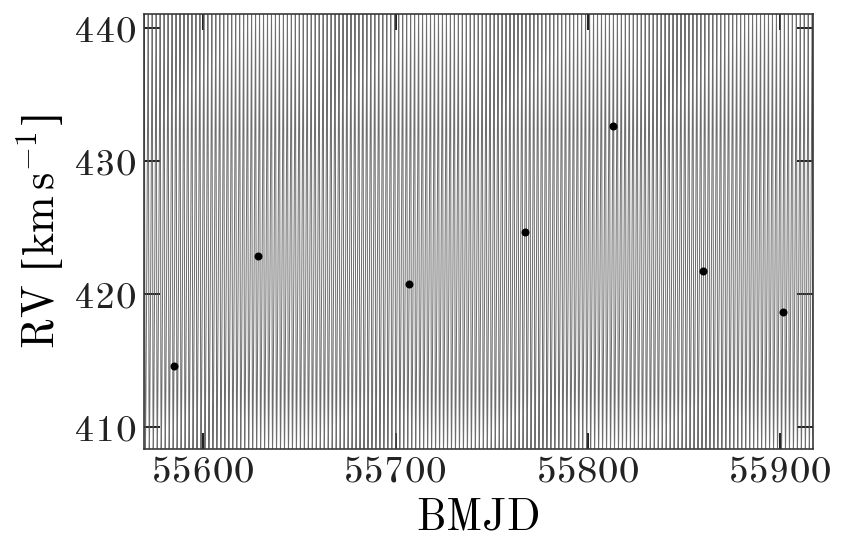

In [9]:
_ = plot_rv_curves(samples, data=data)

Only one sample was returned, and it's not a very good fit to the data. This is because the data were generated from a hierarchical triple system, but fit as a two-body system: in this case, the true system consists of an inner, short-period binary and an outer much longer term orbit. Let's now try generating Keplerian orbit samples for the inner binary, while including a polynomial trend in velocity to capture the long-term trend from the outer companion. To do this, we specify the number of polynomial trend coefficients to sample over: 1 is constant, 2 is linear, 3 is quadratic, etc.:

In [10]:
prior_trend = JokerPrior.default(P_min=2*u.day, P_max=1024*u.day,
                                 sigma_K0=30*u.km/u.s,
                                 sigma_v=[100*u.km/u.s, 0.2*u.km/u.s/u.day],
                                 poly_trend=2)

joker_trend = TheJoker(prior_trend)
prior_samples_trend = prior.sample(size=1_000_000)
samples_trend = joker_trend.rejection_sample(data, prior_samples_trend)

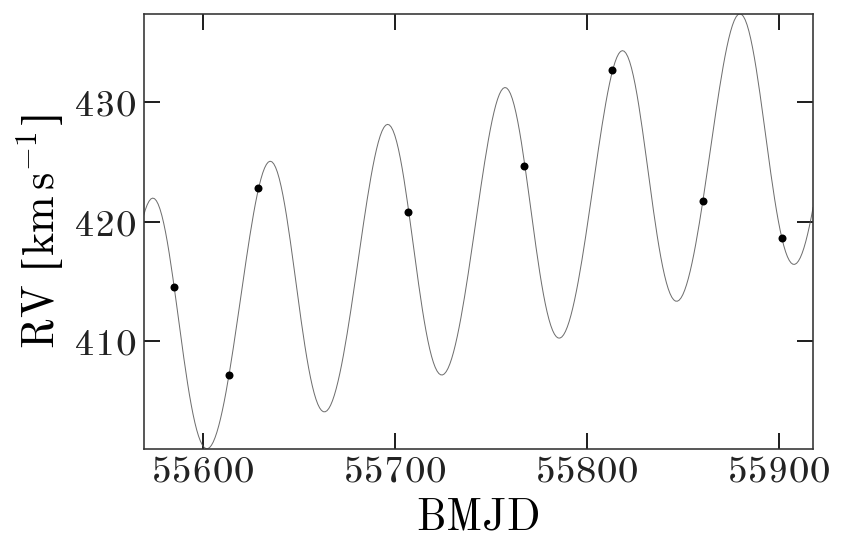

In [11]:
_ = plot_rv_curves(samples_trend, data=data)

Visually, this does a much better job of fitting the data. But how do the system parameters compare to the true values?

In [12]:
samples_trend['P'], true_P

(<Quantity [61.1337643] d>, <Quantity 61.1166 d>)

In [13]:
samples_trend['e'], true_e

(<Quantity [0.04700045]>, 0.0324)

Even though only one sample is returned here, they are very close to the truth! To generate more samples for this system, we would either need to greatly increase the number of prior samples, or hope that the posterior is unimodal and run standard MCMC.

## Putting priors on the trend parameters

By default, when generating posterior samples in the trend parameters, we adopt very wide Gaussian priors on each parameter individually (i.e. we assume they are uncorrelated). You can specify the Gaussian widths (or covariances) if you want to limit the trend parameters. For example, using the above data, we may want to try using a quadratic trend in velocity, but we may want to limit the magnitude of the quadratic coefficient (which has units velocity / day^2). Here we'll put a stronger prior on the linear and quadratic coefficients by specifying the standard deviations of the Gaussian priors on those parameters. We then construct an inverse-variance matrix for the linear parameters Gaussian prior using these standard deviations. The first parameter in the matrix is for the velocity amplitude, K, and the others are for the trend coefficients (constant, linear, quadratic for the example below):

In [ ]:
linear_par_sigmas = np.array([1e3, 1e3, 1e0, 1e-4]) # standard deviations
linear_par_Lambda = np.diag(linear_par_sigmas**2)

In [ ]:
params_trend_prior = JokerParams(P_min=2*u.day, P_max=1024*u.day,
                                 poly_trend=3, 
                                 linear_par_Lambda=linear_par_Lambda)

joker_trend_prior = TheJoker(params_trend_prior)
samples_trend_prior = joker_trend_prior.rejection_sample(data, 
                                                         n_prior_samples=2**20)

In [ ]:
_ = plot_rv_curves(samples_trend_prior, data=data)